In [175]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import myUtils as utils
import seaborn as sns

tech = "battery"  #biogas,battery, biomass, ror, geothermal，transmission， warm, bev
rootPath = f"../../results/scenario/{tech}"
pathTail = "/networks/base_s_27_3H_3H_2045.nc"

nBase = pypsa.Network(f"../../results/scenario/base{pathTail}")
nMean = pypsa.Network(f"{rootPath}_mean/{pathTail}")
nGood = pypsa.Network(f"{rootPath}_good/{pathTail}")
nBest = pypsa.Network(f"{rootPath}_best/{pathTail}")

networks = {
  "Sehr Optimistisch": nBest,
  "Optimistisch": nGood,
  "Mittel": nMean,
  "Basis": nBase, 
}

INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [155]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)


def getDfValue (n):
  lists = [
    n.statistics.capex().sum() / 1e9,
    n.statistics.capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.expanded_capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.opex(groupby="de_grouper").sum() / 1e9,

    n.statistics.capex(groupby="de_all_generator_grouper").sum() / 1e9,
    # n.statistics.opex(groupby="de_all_generator_grouper").sum() / 1e9,
  ]
  return lists

data = {
  'Name': [
    "CAPEX(inkl. Nachbarländer)",
    "CAPEX",
    "investierte CAPEX",
    "OPEX",

    "Strom CAPEX",
    # "Strom Opex"
  ],
  # 'Unit': [
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR'
  # ],
  'Base': getDfValue(nBase),
  'Mittel': getDfValue(nMean),
  'Opt.': getDfValue(nGood),
  'S. Opt.': getDfValue(nBest)
}
print(len(data['Name']), len(data['Name']), len(data['Base']))



df = pd.DataFrame(data).set_index('Name')

caepx_base = df.loc['CAPEX', 'Base']
caepx_changes = (df.loc['CAPEX', ['Mittel', 'Opt.', 'S. Opt.']] - caepx_base) / caepx_base * 100

elc_caepx_base = df.loc['Strom CAPEX', 'Base']
elc_caepx_changes = (df.loc['Strom CAPEX', ['Mittel', 'Opt.', 'S. Opt.']] - elc_caepx_base) / elc_caepx_base * 100
df = df.drop(columns=['Base'])

df = df.T
table = utils.dataframe_to_table(df)
print(table)
print(caepx_changes)
print(elc_caepx_changes)

5 5 5
  [Mittel], [615,24], [71,17], [59,58], [4,95], [31,31],
  [Opt.], [611,88], [70,78], [59,51], [4,92], [31,38],
  [S. Opt.], [605,60], [68,66], [57,87], [4,88], [30,53],
Mittel    -5.01446
Opt.      -5.53497
S. Opt.   -8.36731
Name: CAPEX, dtype: float64
Mittel    -11.49293
Opt.      -11.28885
S. Opt.   -13.70658
Name: Strom CAPEX, dtype: float64


In [168]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)


def getDfValue (n):
  lists = [
    n.statistics.capex().sum() / 1e9,
    n.statistics.capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.expanded_capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.opex(groupby="de_grouper").sum() / 1e9,

    n.statistics.capex(groupby="de_all_generator_grouper").sum() / 1e9,
    n.statistics.opex(groupby="de_all_generator_grouper").sum() / 1e9,
  ]
  return lists

data = {
  'Name': [
    "CAPEX(inkl. Nachbarländer)",
    "CAPEX",
    "investierte CAPEX",
    "OPEX",

    "Strom CAPEX",
    "Strom Opex"
  ],
  # 'Unit': [
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR'
  # ],
  'Base': getDfValue(nBase),
  'Mean': getDfValue(nMean),
  'Optimist': getDfValue(nGood),
  'Best': getDfValue(nBest)
}
print(len(data['Name']), len(data['Name']), len(data['Base']))



df = pd.DataFrame(data).set_index('Name')

caepx_base = df.loc['CAPEX', 'Base']
caepx_changes = (df.loc['CAPEX', ['Mean', 'Optimist', 'Best']] - caepx_base) / caepx_base * 100

elc_caepx_base = df.loc['Strom CAPEX', 'Base']
elc_caepx_changes = (df.loc['Strom CAPEX', ['Mean', 'Optimist', 'Best']] - elc_caepx_base) / elc_caepx_base * 100

table = utils.dataframe_to_table(df)
print(table)
print(caepx_changes)
print(elc_caepx_changes)

6 6 6
  [CAPEX(inkl. Nachbarländer)], [637,33], [606,44], [606,76], [603,36],
  [CAPEX], [74,93], [69,73], [69,67], [69,43],
  [investierte CAPEX], [63,34], [58,14], [58,08], [57,84],
  [OPEX], [5,49], [7,40], [7,03], [6,42],
  [Strom CAPEX], [35,38], [32,17], [32,17], [32,17],
  [Strom Opex], [0,13], [0,14], [0,14], [0,14],
Mean       -6.93368
Optimist   -7.01305
Best       -7.33459
Name: CAPEX, dtype: float64
Mean       -9.07135
Optimist   -9.07135
Best       -9.07139
Name: Strom CAPEX, dtype: float64


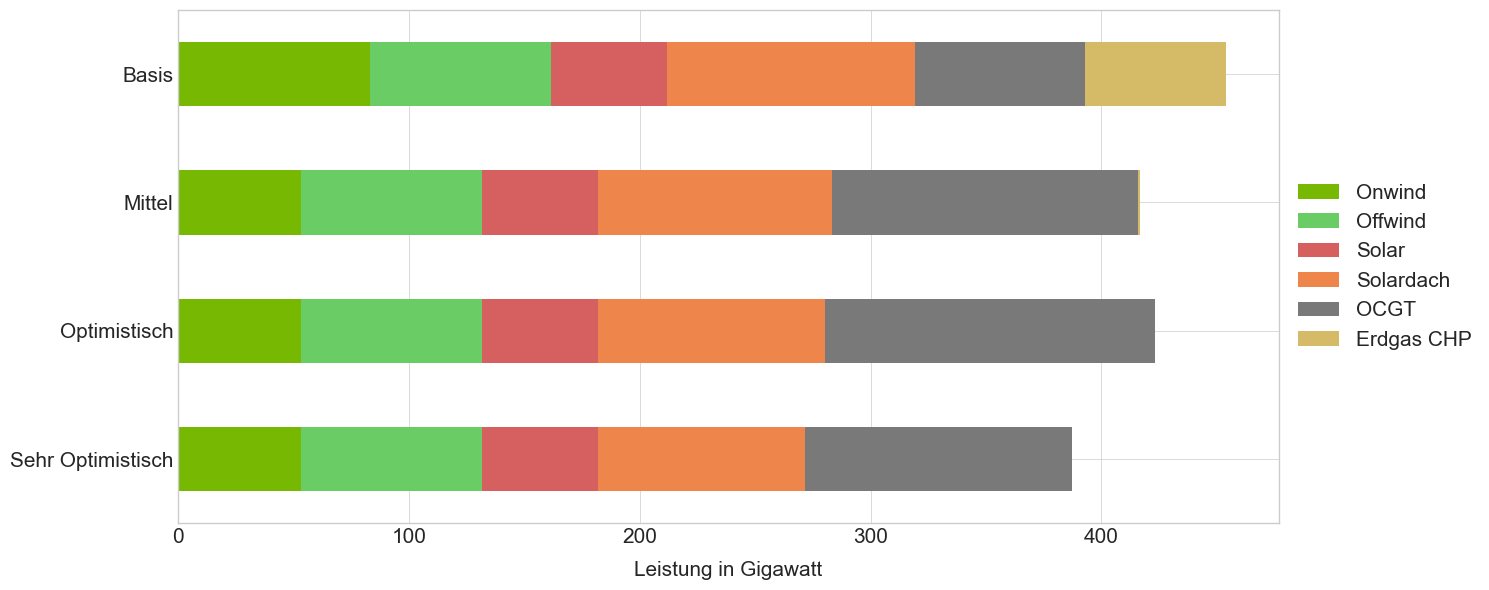

In [157]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)

plt.style.use('seaborn-v0_8-muted')
sns.color_palette("muted", 12)
%matplotlib inline

df = pd.DataFrame()

for key, n in networks.items():
  generator_df = utils.getNByGroup(n, 'Generator', utils.de_generator_grouper)
  generators = generator_df.groupby('carrier').sum().p_nom_opt / 1e3
  g_links_df = utils.getNByGroup(n, 'Link', utils.de_generator_grouper)
  generatorLinks = g_links_df.groupby('carrier').sum().p_nom_opt / 1e3

  battery_df = utils.getNByGroup(n, 'Link', utils.de_battery_discharger)
  battery_home_df = utils.getNByGroup(n, 'Link', utils.de_home_battery_discharger)

  V2G_df = utils.getNByGroup(n, 'Link', utils.de_v2g)

  h2_FC =utils.getNByGroup(n, 'Link', utils.de_h2_FC_grouper)
  h2_turbine =utils.getNByGroup(n, 'Link', utils.de_h2_turbine_grouper)

  ror = utils.getNByGroup(n, 'Generator', utils.de_ror_generator_grouper)

  h2_df = utils.getNByGroup(n, 'Link', utils.de_h2_dispatch_grouper)
  h2s =  h2_df.groupby('carrier').sum().p_nom_opt / 1e3

  biomass = utils.getNByGroup(n,'Link',utils.de_biomass_chp)
  # print(biomass)
  s = pd.concat([generators, generatorLinks,h2s])
  s['Offwind'] = s['offwind-ac'] + s['offwind-dc'] + s['offwind-float']
  s['Solar'] = s['solar'] + s['solar-hsat']
  s['Onwind'] = s['onwind']
  

  s['Solardach'] = s['solar rooftop']
  s['Erdgas CHP'] = s['urban central CHP']
  s['Geothermal'] = s.get('geothermal organic rankine cycle', 0)
  s['Biomasse CHP'] = biomass.p_nom_opt.sum()  / 1e3
  s['Batterie'] = battery_df.p_nom_opt.sum() / 1e3 
  s['Heimbatterie'] =   battery_home_df.p_nom_opt.sum() / 1e3
  s['V2G'] = V2G_df.p_nom_opt.sum() / 1e3
  s['H2 Brennstoffzelle'] = h2_FC.p_nom_opt.sum() / 1e3
  s['H2 Turbine'] = h2_turbine.p_nom_opt.sum() / 1e3
  s['ROR'] = ror.p_nom_opt.sum() / 1e3
  # s['Gesamt'] = s.sum()
  
  s = s.reindex(['Onwind', 'Offwind', 'Solar', 'Solardach','OCGT', 'Erdgas CHP',
                #  'Geothermal', 'Biomasse CHP', 'ROR', 
                #  'Batterie', 'Heimbatterie'
                # , 'Biomasse CHP'
                # ,'H2 Brennstoffzelle', 'H2 Turbine'
                # , 'Geothermal'
                #  'V2G'
                # "ROR"
                 ])
  df[key] = s

# df = df[(df != 0).any(axis=1)]
df = df.fillna(0)


# print(utils.dataframe_to_table(df))

# print(df)
df_transposed = df.transpose()
# df_transposed = df_transposed[['Basis', 'Mittel', 'Optimistisch', 'Sehr Optimistisch']]

color = {
  'Onwind': '#76B802',
  'Offwind': '#6ACC64',
  'Solar': '#D65F5F',
  'Solardach': '#EE854A',
  'OCGT': '#797979',
  'Erdgas CHP': '#D5BB67',
  'Batterie': '#97AED9',
  'Heimbatterie': '#D5E5EC',
  'V2G': '#97AED9',
  'Biomasse CHP': '#97AED9',
  'Geothermal': '#97AED9',
  'H2 Brennstoffzelle': '#97AED9',
  'H2 Turbine': '#D5E5EC',
  "ROR": "#D5E5EC"
}

ax = df_transposed.plot(kind="barh", stacked=True,figsize=(15,6), color= color, fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)

ax.set_xlabel('Leistung in Gigawatt',labelpad=10, fontsize=15)

plt.tight_layout()
plt.show()

In [176]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)

plt.style.use('seaborn-v0_8-muted')
sns.color_palette("muted", 12)
%matplotlib inline

df = pd.DataFrame()

for key, n in networks.items():
  print(key)
  generator_df = utils.getNByGroup(n, 'Generator', utils.de_generator_grouper)
  generators = generator_df.groupby('carrier').sum().p_nom_opt / 1e3
  g_links_df = utils.getNByGroup(n, 'Link', utils.de_generator_grouper)
  generatorLinks = g_links_df.groupby('carrier').sum().p_nom_opt / 1e3

  battery_df = utils.getNByGroup(n, 'Link', utils.de_battery_discharger)
  battery_home_df = utils.getNByGroup(n, 'Link', utils.de_home_battery_discharger)

  V2G_df = utils.getNByGroup(n, 'Link', utils.de_v2g)

  h2_FC =utils.getNByGroup(n, 'Link', utils.de_h2_FC_grouper)
  h2_turbine =utils.getNByGroup(n, 'Link', utils.de_h2_turbine_grouper)

  ror = utils.getNByGroup(n, 'Generator', utils.de_ror_generator_grouper)

  h2_df = utils.getNByGroup(n, 'Link', utils.de_h2_dispatch_grouper)
  h2s =  h2_df.groupby('carrier').sum().p_nom_opt / 1e3

  biomass = utils.getNByGroup(n,'Link',utils.de_biomass_chp)
  # print(biomass)
  s = pd.concat([generators, generatorLinks,h2s])
  s['Offwind'] = s['offwind-ac'] + s['offwind-dc'] + s['offwind-float']
  s['Solar'] = s['solar'] + s['solar-hsat']
  s['Onwind'] = s['onwind']
  

  s['Solardach'] = s['solar rooftop']
  s['Erdgas CHP'] = s['urban central CHP']
  s['Geothermal'] = s.get('geothermal organic rankine cycle', 0)
  s['Biomasse CHP'] = biomass.p_nom_opt.sum()  / 1e3
  # s['Batterie'] = battery_df.p_nom_opt.sum() / 1e3 
  # s['Heimbatterie'] =   battery_home_df.p_nom_opt.sum() / 1e3
  # s['V2G'] = V2G_df.p_nom_opt.sum() / 1e3
  s['H2 Brennstoffzelle'] = h2_FC.p_nom_opt.sum() / 1e3
  s['H2 Turbine'] = h2_turbine.p_nom_opt.sum() / 1e3
  s['ROR'] = ror.p_nom_opt.sum() / 1e3
  s['Gesamt'] = s.sum()
  
  df[key] = s

# df = df[(df != 0).any(axis=1)]
df = df.fillna(0)

caepx_base = df.loc['Gesamt', 'Basis']
caepx_changes = (df.loc['Gesamt', ['Mittel', 'Optimistisch', 'Sehr Optimistisch']] - caepx_base) / caepx_base * 100

print(caepx_changes)


Sehr Optimistisch
Optimistisch
Mittel
Basis
Mittel              5.05743
Optimistisch        6.45989
Sehr Optimistisch   6.29929
Name: Gesamt, dtype: float64
